In [23]:
"""
============================================================================
FULL COMPARISON: PHASE 2 BASE vs PHASE 3 WITH CLUSTER FEATURES
============================================================================
"""

# ----------------------------
# 0️⃣ Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
import pickle
import os

In [24]:
# ----------------------------
# 1️⃣ Load Phase 2 pickle (supervised results)
# ----------------------------
pickle_file = "supervised_results.pkl"

if not os.path.exists(pickle_file):
    raise FileNotFoundError(f"Pickle file not found: {pickle_file}")

with open(pickle_file, "rb") as f:
    phase2 = pickle.load(f)

X_test = phase2['X_test']
y_home_test = phase2['y_home_test']
y_away_test = phase2['y_away_test']
y_home_pred_rounded = phase2['y_home_pred_rounded']
y_away_pred_rounded = phase2['y_away_pred_rounded']
X_train = phase2.get('X_train')   # optional, if saved
y_home_train = phase2.get('y_home_train')
y_away_train = phase2.get('y_away_train')
model_home_base = phase2.get('model_home_base', LinearRegression())
model_away_base = phase2.get('model_away_base', LinearRegression())

In [25]:
# ----------------------------
# 2️⃣ Load Phase 3 clean dataset with cluster features
# ----------------------------
dataset_file = "../Dataset/phase3_clean_clusters.csv"
if not os.path.exists(dataset_file):
    raise FileNotFoundError(f"Phase 3 clean dataset not found: {dataset_file}")

df_clean = pd.read_csv(dataset_file)
optimal_k = df_clean['Cluster'].nunique()
cluster_cols = ['Cluster'] + [f"Dist_to_Cluster_{i}" for i in range(optimal_k)]
print(f"✓ Found {optimal_k} clusters in Phase 3 clean dataset")

✓ Found 4 clusters in Phase 3 clean dataset


In [26]:
# ----------------------------
# 3️⃣ Prepare X_test/X_train with cluster features
# ----------------------------
X_test_clustered = X_test.copy()
X_train_clustered = X_train.copy() if X_train is not None else None

for col in cluster_cols:
    X_test_clustered[col] = df_clean[col].iloc[-len(X_test):].values
    if X_train_clustered is not None:
        X_train_clustered[col] = df_clean[col].iloc[:len(X_train)].values

In [27]:
# ----------------------------
# 4️⃣ Retrain models with cluster features
# ----------------------------
model_home = clone(model_home_base)
model_home.fit(X_train_clustered, y_home_train)

model_away = clone(model_away_base)
model_away.fit(X_train_clustered, y_away_train)

y_home_pred_clustered = model_home.predict(X_test_clustered)
y_away_pred_clustered = model_away.predict(X_test_clustered)

# Round for comparison with original Phase 2
y_home_pred_clustered_rounded = np.round(y_home_pred_clustered)
y_away_pred_clustered_rounded = np.round(y_away_pred_clustered)

In [28]:
# ----------------------------
# 5️⃣ Compute metrics
# ----------------------------
metrics = {
    'Metric': ['MAE', 'RMSE', 'R2'],
    'Home_Base': [
        mean_absolute_error(y_home_test, y_home_pred_rounded),
        np.sqrt(mean_squared_error(y_home_test, y_home_pred_rounded)),
        r2_score(y_home_test, y_home_pred_rounded)
    ],
    'Home_With_Clusters': [
        mean_absolute_error(y_home_test, y_home_pred_clustered_rounded),
        np.sqrt(mean_squared_error(y_home_test, y_home_pred_clustered_rounded)),
        r2_score(y_home_test, y_home_pred_clustered_rounded)
    ],
    'Away_Base': [
        mean_absolute_error(y_away_test, y_away_pred_rounded),
        np.sqrt(mean_squared_error(y_away_test, y_away_pred_rounded)),
        r2_score(y_away_test, y_away_pred_rounded)
    ],
    'Away_With_Clusters': [
        mean_absolute_error(y_away_test, y_away_pred_clustered_rounded),
        np.sqrt(mean_squared_error(y_away_test, y_away_pred_clustered_rounded)),
        r2_score(y_away_test, y_away_pred_clustered_rounded)
    ]
}

df_metrics = pd.DataFrame(metrics)
print("\n" + "="*80)
print("COMPARISON OF MODELS: BASE vs WITH CLUSTERS")
print("="*80)
print(df_metrics)


COMPARISON OF MODELS: BASE vs WITH CLUSTERS
  Metric  Home_Base  Home_With_Clusters  Away_Base  Away_With_Clusters
0    MAE   0.955521            0.947853   0.837423            0.831288
1   RMSE   1.281654            1.258103   1.168345            1.145811
2     R2   0.032611            0.067838   0.026172            0.063374


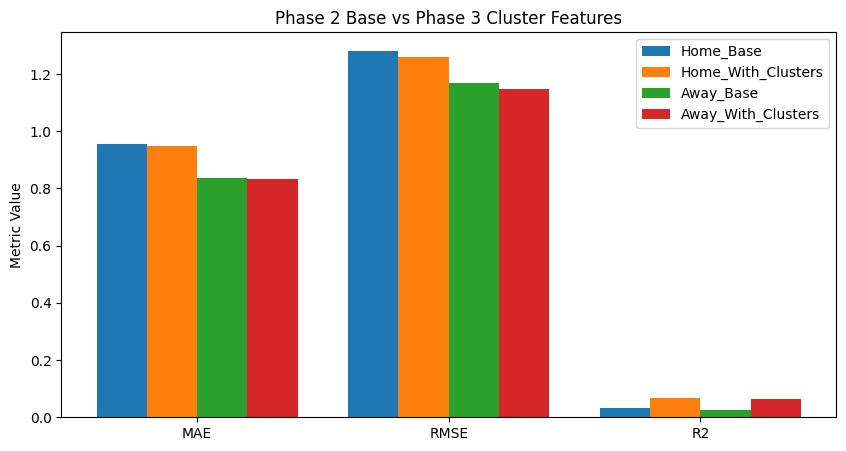

In [29]:
# ----------------------------
# 6️⃣ Visualization
# ----------------------------
plt.figure(figsize=(10,5))
x = np.arange(len(df_metrics))
width = 0.2

plt.bar(x - width*1.5, df_metrics['Home_Base'], width, label='Home_Base')
plt.bar(x - width*0.5, df_metrics['Home_With_Clusters'], width, label='Home_With_Clusters')
plt.bar(x + width*0.5, df_metrics['Away_Base'], width, label='Away_Base')
plt.bar(x + width*1.5, df_metrics['Away_With_Clusters'], width, label='Away_With_Clusters')

plt.xticks(x, df_metrics['Metric'])
plt.ylabel("Metric Value")
plt.title("Phase 2 Base vs Phase 3 Cluster Features")
plt.legend()
plt.show()